In [6]:
import sys
sys.path.append('/home/g007markphillip/model_artifacts2/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from src.models import Eff
import tensorflow as tf
from src.data.dataset import TrainGenerator,TestGenerator
import numpy as np
import cv2

In [19]:
# model = Eff('efficientnetB0_noisystudent',False)
# latest=tf.train.latest_checkpoint('/home/g007markphillip/model_artifacts2/models/weights/efficientnetB0_noisystudent/2022-10-31-18:52:09/')
model.load_weights('/home/g007markphillip/model_artifacts2/models/weights/efficientnetB0_noisystudent/2022-10-31-18:52:09/cp-0320.ckpt')

In [20]:
# latest

In [33]:
test_data = TrainGenerator(1).batch(16)

In [34]:
pred_classes=[]
true_classes=[]
for img,classes in test_data:
    pred_classes.append(model(img))
    true_classes.append(classes)

In [35]:
preds=tf.concat(pred_classes,axis=0).numpy()
trues=tf.concat(true_classes,axis=0).numpy().astype('int')

In [36]:
preds

array([[0.42017108, 0.32861796, 0.20498733, 0.09501814],
       [0.36294764, 0.20631744, 0.4127251 , 0.04099483],
       [0.16816463, 0.2287242 , 0.73924196, 0.14415064],
       ...,
       [0.10625917, 0.81409085, 0.09757212, 0.00241614],
       [0.0260414 , 0.96674913, 0.16241299, 0.00581325],
       [0.07877189, 0.32858565, 0.70149404, 0.6982846 ]], dtype=float32)

In [37]:
preds_=(preds>0.7).astype('int')

In [38]:
preds_

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [39]:
# p=[]
# for i in range(len(preds)):
#     if (preds[i]>0.6).any()==False:
#         k = np.argmax(preds[i])
#         l = np.zeros(4)
#         l[k]=1
#         p.append(l)
#     else:
#         p.append((preds[i]>0.7).astype('int'))

In [40]:
# preds_=np.array(p).astype('int')

In [41]:
trues

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 1]])

[[[ 927    0]
  [ 342    9]]

 [[ 801    7]
  [ 191  279]]

 [[ 826    0]
  [ 235  217]]

 [[1097    1]
  [  98   82]]]


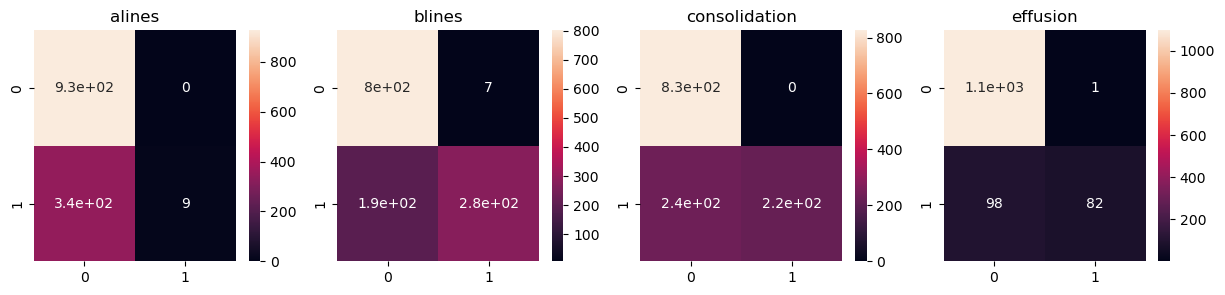

In [42]:
cm=multilabel_confusion_matrix(trues, preds_)
print(np.array(cm))
classes=['alines','blines','consolidation','effusion']
fig,axes = plt.subplots(1,4,figsize=(15,3))

a=0
for i in range(4):
    sns.heatmap(ax=axes[i],data=cm[a],annot=True)
    axes[i].set_title(classes[a])
    a+=1

plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
last_conv_layer_name='top_conv'
model_.layers[-1].activation = None


In [ ]:
import matplotlib.cm as cm
def display_(heatmap,image):
    alpha = 0.4
    heatmap = np.uint8(255 *heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    return superimposed_img/255.

In [ ]:
def display_results(df):

    fig,axes=plt.subplots(10,2,figsize=(15,50))
    classes=np.array(['alines','blines','consolidation','effusion'])
    a=0
    for i in range(10):
        k=cv2.imread(df.image.values.tolist()[a])
        k=cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
        k = cv2.resize(k,(224,224))
        axes[i,0].set_title(df[['alines','blines','consolidation','effusion']].values[a])
        axes[i,0].imshow(k)
        heatmap = make_gradcam_heatmap(np.expand_dims(k,0), model_, last_conv_layer_name)
        superimposed_img =display_(heatmap,k)
        axes[i,1].imshow(superimposed_img)
        a+=1

    plt.show()

In [ ]:
display_results(true_preds)

In [2]:
v = TrainGenerator(4)

/home/g007markphillip/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Exception ignored in: <generator object TrainGenerator.generator at 0x7fc3203b2350>
Traceback (most recent call last):
  File "/home/g007markphillip/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 727, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


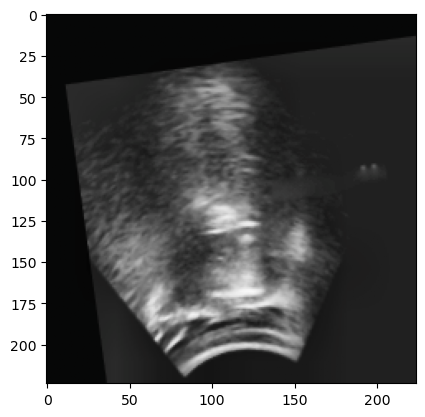

In [11]:
plt.imshow(list(v.take(1))[0][0].numpy()/255)